# Laboratorium 2 - Klasyfikacja algorytmem k-najbliższych sąsiadów (k-nn)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris, load_wine
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut, GridSearchCV
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline

### Klasyfikacja k-nn dla zbioru IRIS

In [2]:
iris = load_iris()
df_iris = pd.DataFrame(data = iris.data, columns = iris.feature_names)
df_iris['target'] = iris.target
df_iris['target names'] = iris.target_names[df_iris['target']]
df_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target names
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


In [3]:
# Dystrybucja klas w zbiorze
class_labels = iris.target
unique_classes, counts = np.unique(class_labels, return_counts = True)

for i, class_name in enumerate(iris.target_names):
    print(f'{class_name}: {counts[i]}')

setosa: 50
versicolor: 50
virginica: 50


In [4]:
df_iris.isna().any()

sepal length (cm)    False
sepal width (cm)     False
petal length (cm)    False
petal width (cm)     False
target               False
target names         False
dtype: bool

In [5]:
df_iris.iloc[:, :4].columns

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)'],
      dtype='object')

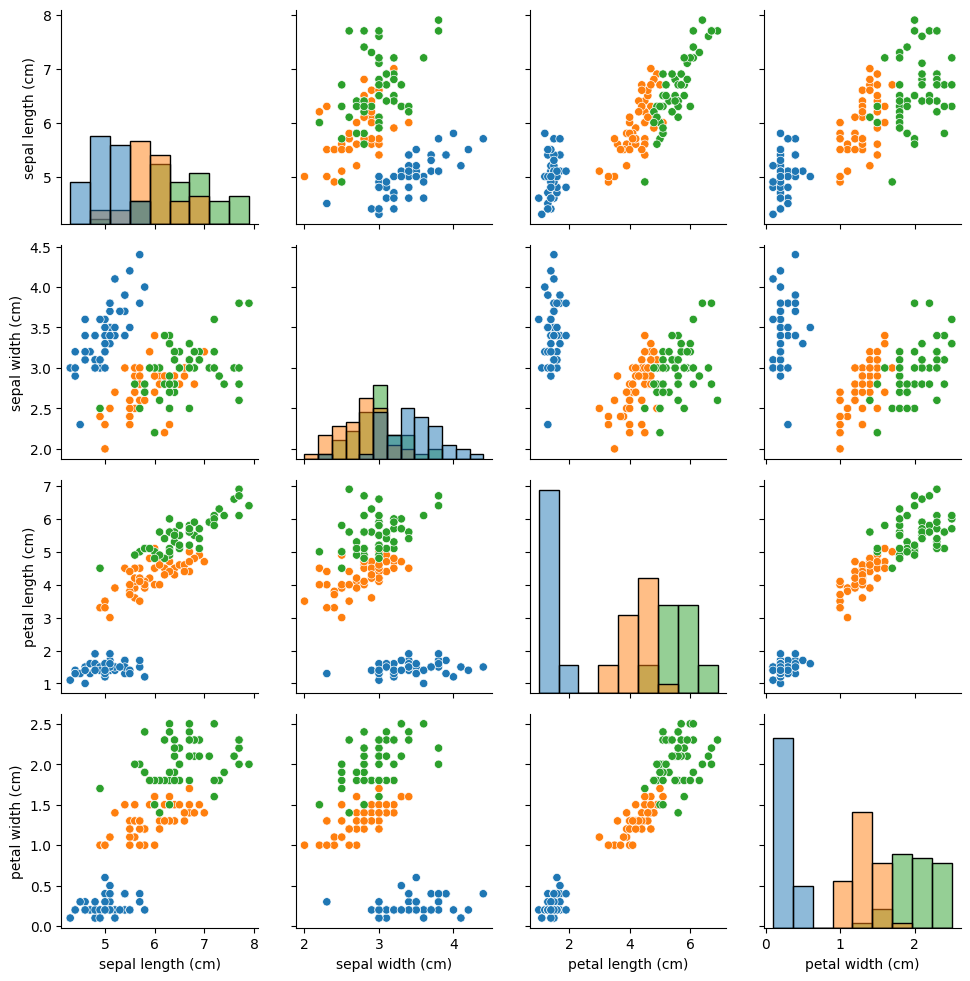

In [6]:
x_vars = df_iris.iloc[:, :4].columns
y_vars = x_vars

g = sns.PairGrid(df_iris, hue = 'target names', x_vars = x_vars, y_vars = y_vars)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
plt.show()

In [30]:
X_iris = iris.data
y_iris = iris.target

In [31]:
def plain_knn(X = X_iris, y = y_iris, n_neighbors = 5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)
    
    pipe = Pipeline([('normalize', Normalizer()), ('knn', KNeighborsClassifier(n_neighbors = n_neighbors))])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    return y_test, y_pred

In [32]:
plain_knn_iris = plain_knn()
print(classification_report(*plain_knn_iris))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      0.92      0.96        13
           2       0.93      1.00      0.96        13

    accuracy                           0.97        38
   macro avg       0.98      0.97      0.97        38
weighted avg       0.98      0.97      0.97        38



In [33]:
print(f'Precision: {precision_score(*plain_knn_iris, average = "weighted")}')
print(f'Accuracy: {accuracy_score(*plain_knn_iris)}')
print(f'Recall: {recall_score(*plain_knn_iris, average = "weighted")}')
print(f'F1: {f1_score(*plain_knn_iris, average = "weighted")}')

Precision: 0.9755639097744361
Accuracy: 0.9736842105263158
Recall: 0.9736842105263158
F1: 0.9736452241715399


### 4. Implementacja procedury walidacji krzyżowej

In [78]:
def cv_knn(n_splits, X = X_iris, y = y_iris, shuffle = True, n_neighbors = 5, metric = "minkowski", p = 2, metric_params = None, weights = None):

    kf = KFold(n_splits = n_splits, shuffle = shuffle)
    pipe = Pipeline([('normalize', Normalizer()), ('knn', KNeighborsClassifier(n_neighbors = n_neighbors
                                                                               , metric = metric
                                                                               , p = p
                                                                               , metric_params = metric_params
                                                                               , weights = weights))])
    scores = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        scores.append(score)

    # Średnia dokładność z k-fold walidacji
    mean_score = np.mean(scores)
    return mean_score


def loo_knn(X = X_iris, y = y_iris, n_neighbors = 5):

    loo = LeaveOneOut()
    loo.get_n_splits(X)
    pipe = Pipeline([('normalize', Normalizer()), ('knn', KNeighborsClassifier(n_neighbors = n_neighbors))])
    scores = []
    
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        scores.append(score)

    # Średnia dokładność z k-fold walidacji
    mean_score = np.mean(scores)
    return mean_score

In [79]:
print('KFold accuracy without shuffling: \n')
print(f'2-fold CV accuracy: {cv_knn(2, shuffle = False)}')
print(f'5-fold CV accuracy: {cv_knn(5, shuffle = False)}')
print(f'10-fold CV accuracy: {cv_knn(10, shuffle = False)}')

KFold accuracy without shuffling: 

2-fold CV accuracy: 0.30666666666666664
5-fold CV accuracy: 0.9400000000000001
10-fold CV accuracy: 0.9533333333333334


In [80]:
print('KFold accuracy with shuffling: \n')
print(f'2-fold CV accuracy: {cv_knn(2)}')
print(f'5-fold CV accuracy: {cv_knn(5)}')
print(f'10-fold CV accuracy: {cv_knn(10)}')

KFold accuracy with shuffling: 

2-fold CV accuracy: 0.9666666666666667
5-fold CV accuracy: 0.9666666666666666
10-fold CV accuracy: 0.96


Implementacja walidacji krzyżowej z uwzględnieniem parametru shuffle skutkuje znacznie lepszymi rezultatami, aniżeli bez niego. Dzieje się tak, ponieważ odpowiada on za losowe przemieszanie zbioru danych przed jego podziałem na foldy. Gdy jest on ustawiony na False, to dzieli on dane w takiej kolejności, w jakiej występują w zbiorze. W przypadku IRIS dane są wyraźnie posegregowane - najpierw występują kwiaty z klasy 0, później klasy 1, a na końcu z klasy 2. Ponieważ są one różne pod względem cech, przemieszanie zbioru jest niezbędne w celu uzyskania wiarygodnych wyników.

In [41]:
print('LeaveOneOut accuracy: \n')
print(f'LOO accuracy: {loo_knn()}')


LeaveOneOut accuracy: 

LOO accuracy: 0.9666666666666667


### 5. Testowanie różnych wartości hiperparametrów

#### a) Liczba sąsiadów
Sprawdzimy zmianę jakości klasyfikatora knn względem zmiany argumentu k - liczby sąsiadów. Metryka zostaje domyślna, czyli euklidesowa.

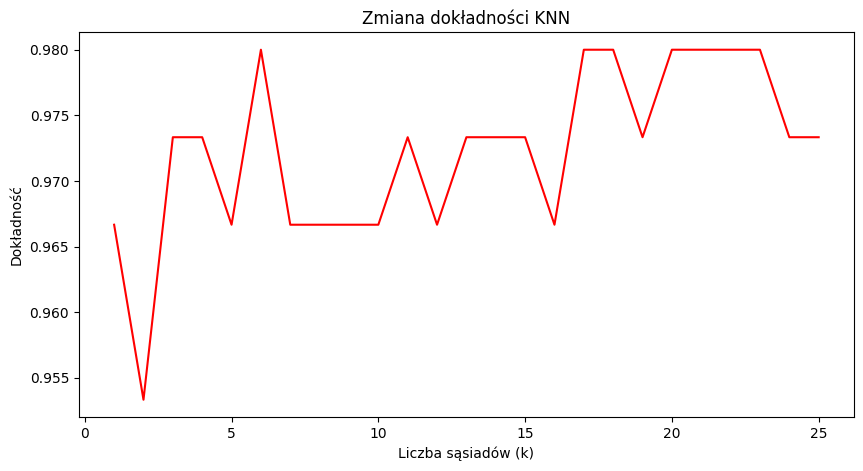

In [81]:
def plot_acc_change(k = 25):
    neighbors = np.arange(1, k + 1)
    accuracy = np.array([cv_knn(10, n_neighbors = n) for n in neighbors])
    fig = plt.figure(figsize = (10, 5))
    plt.plot(neighbors, accuracy, color = 'red')
    plt.xlabel('Liczba sąsiadów (k)')
    plt.ylabel('Dokładność')
    plt.title('Zmiana dokładności KNN')
    plt.show()

plot_acc_change()

#### b) Metryka
Teraz będziemy rozważali różne metryki i na ich podstawie badali dokładność KNN.

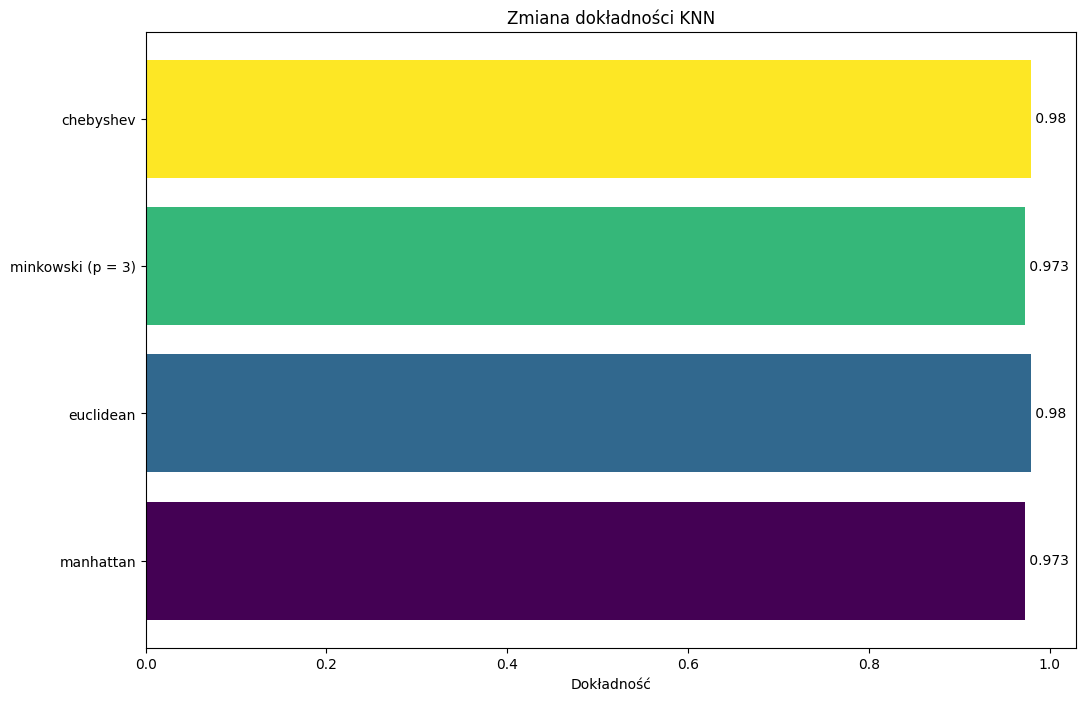

In [112]:
def metrics_plot(X = X_iris):
    accuracy = [cv_knn(10, n_neighbors = 3, metric = "manhattan", p = None, metric_params = None)
               , cv_knn(10, n_neighbors = 3, metric = "euclidean", p = None, metric_params = None)
               , cv_knn(10, n_neighbors = 3, metric = "minkowski", p = 3, metric_params = None)
            #    , cv_knn(10, n_neighbors = 3, metric = "mahalanobis", p = None, metric_params={'V': np.cov(X)})
               , cv_knn(10, n_neighbors = 3, metric = "chebyshev", p = None)]
    metrics = ['manhattan', 'euclidean', 'minkowski (p = 3)', 'chebyshev']
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(metrics)))
    fig, ax = plt.subplots(figsize = (12, 8))
    
    ax.barh(metrics, accuracy, color = colors)
    for i, (value, name) in enumerate(zip(accuracy, metrics)):
        ax.text(x = value, y=i, s=f' {round(float(value), 3)}',
            ha='left', va='center', fontsize=10)
    # plt.xlabel('Liczba sąsiadów (k)')
    plt.xlabel('Dokładność')
    plt.title('Zmiana dokładności KNN')
    plt.show()

metrics_plot()

#### c) Sposób głosowania
Tym razem sprawdzimy, jaki wpływ ma sposób głosowania nad przydzieleniem do klasy na osiąganą dokładność. Parametry liczby sąsiadów, oraz metryki pozostaną standardowe. 

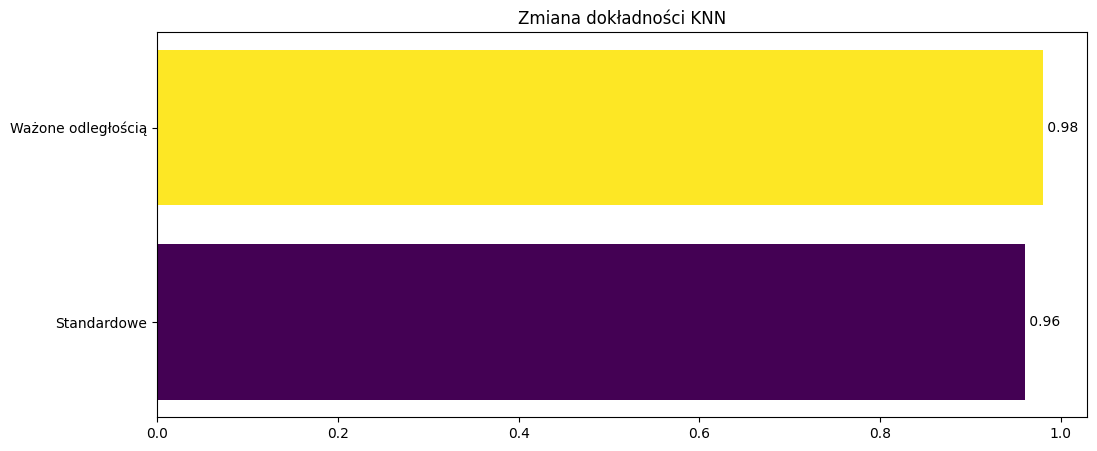

In [92]:
def voting_plot(X = X_iris):
    accuracy = [cv_knn(10, weights = None)
               , cv_knn(10, weights = 'distance')]
    voting = ['Standardowe', 'Ważone odległością']
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(voting)))
    fig, ax = plt.subplots(figsize = (12, 5))
    
    ax.barh(voting, accuracy, color = colors)
    for i, (value, name) in enumerate(zip(accuracy, voting)):
        ax.text(x = value, y=i, s=f' {round(float(value), 3)}',
            ha='left', va='center', fontsize=10)
    plt.xlabel('Dokładność')
    # plt.ylabel('Dokładność')
    plt.title('Zmiana dokładności KNN')
    plt.show()

voting_plot()

#### d) Optymalne hiperparametry na podstawie algorytmu GridSearchCV
W celu wyznaczenia optymalnego zestawu hiperparametrów do klasyfikatora KNN zastosujemy algorytm GridSearchCV.

In [117]:
def optimal_model(X = X_iris, y = y_iris):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)
    grid = {
        'knn__n_neighbors' : [(i + 1) for i in range(15)]
        , 'knn__weights' : ['uniform', 'distance']
        , 'knn__metric': ['minkowski']
        , 'knn__p' : [1, 2, 3]
    }
    
    pipe = Pipeline([('scaler', Normalizer()), ('knn', KNeighborsClassifier())])
    
    grid_search = GridSearchCV(pipe, grid, cv = 10, n_jobs = -1)
    grid_search.fit(X_train, y_train)
    
    best_params, best_estimator = grid_search.best_params_, grid_search.best_estimator_
    y_pred = best_estimator.predict(X_test)
    print(best_params)
    print(f'Accuracy: {accuracy_score(y_pred, y_test)}')
    
optimal_model()

{'knn__metric': 'minkowski', 'knn__n_neighbors': 5, 'knn__p': 2, 'knn__weights': 'uniform'}
Accuracy: 0.9736842105263158


## Zbiór WINE

In [4]:
wine = load_wine()
df_wine = pd.DataFrame(data = wine.data, columns = wine.feature_names)
df_wine['target'] = wine.target
df_wine['target names'] = wine.target_names[df_wine['target']]
df_wine.wine()

AttributeError: 'DataFrame' object has no attribute 'wine'

## Zbiór GLASS